<a href="https://colab.research.google.com/github/pitthexai/ICHI2023_EBAIC/blob/main/EBAIC2024_Workshop/Track02_Medical-Imaging-Informatics/EBAIC2024_KneeSegmentationBiasEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EBAIC 2024 Track II: Medical Imaging Informatics: Fair Knee Anatomy Segmentation

AI fairness in medical image analysis is a critical aspect in the development of fair AI and deep learning models in healthcare settings. For instance, an accurate and reliable segmentation of medical images is essential for precise disease diagnosis, personalized treatment planning, and effective patient monitoring. However, when fairness is not adequately addressed, these AI models can inadvertently perpetuate biases and disparities in healthcare delivery. Fairness in medical image segmentation ensures that the AI algorithms do not discriminate against individuals based on their race, gender, socioeconomic status, or any other demographic factors. It aims to provide equitable healthcare outcomes for all patients, irrespective of their background or characteristics.

Upholding fairness in AI models for medical image segmentation is not only an ethical imperative but also crucial for building trust in AI systems within the medical community and among patients. Transparent and accountable AI algorithms, coupled with comprehensive data collection and evaluation, can help identify and rectify biases present in the training data or the algorithmic decision-making process. This iterative process of refinement and evaluation ensures that AI models produce consistent and equitable results, contributing to the overall quality and fairness of healthcare delivery.


## Package Setup

In [ ]:
!pip install segmentation-models-pytorch albumentations torchmetrics pydicom nibabel

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import copy

from zipfile import ZipFile

from io import BytesIO
from gzip import GzipFile

import os

import cv2
from PIL import Image

import pydicom
import nibabel
from nibabel import FileHolder, Nifti1Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

from torchmetrics.classification import MulticlassJaccardIndex, Dice
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
RANDOM_STATE = 42

## Step 1: Data Preprocessing

In [ ]:
# Directories for

filename = "knee_seg_sample.csv"
directory = "KneeSample"
zipfile = "knee_sample.zip"

classes = {
    0: "Background",
    1: "R Patella",
    2: "R Femur",
    3: "R Tibia",
    4: "R Fibula",
    5: "L Patella",
    6: "L Femur",
    7: "L Tibia",
    8: "L Fibula"
}

zipfile_loc = f"/content/drive/MyDrive/GoogleColabProjects/EBAIC_2024/KneeDataset/{zipfile}"
data_location = f"/content/data/{directory}/{filename}"
data_save_location = f"/content/data/{directory}/"

In [ ]:
if not os.path.exists(data_save_location):
    with ZipFile(zipfile_loc, 'r') as zipf:
        zipf.extractall("/content/")

In [ ]:
def generate_train_test_split(csv_pth, filter_query=None):
    data_records = pd.read_csv(csv_pth)
    data_records = data_records[data_records.id != 9025994].reset_index(drop=True)
    if filter_query:
        data_records = data_records.query(filter_query)

    train, test = train_test_split(data_records.id.unique(), test_size=0.3, random_state=42)
    valid, test = train_test_split(test, test_size=0.5, random_state=42)

    train = data_records[data_records.id.isin(train)].reset_index(drop=True)
    valid = data_records[data_records.id.isin(valid)].reset_index(drop=True)
    test = data_records[data_records.id.isin(test)].reset_index(drop=True)

    return train, valid, test

In [ ]:
def balance_dataset(data, by_filter1, by_filter2):
    filtered1 = data.query(by_filter1)
    filtered2 = data.query(by_filter2)

    min_sample_size = np.minimum(len(filtered1), len(filtered2))
    samp1 = filtered1.sample(min_sample_size,  random_state = 42)
    samp2 = filtered2.sample(min_sample_size,  random_state = 42)

    balanced_data = pd.concat([samp1, samp2]).reset_index(drop=True)

    print(f"Training dataset reduced from size of {len(data)} samples to a balanced dataset of size {len(balanced_data)} samples")

    return balanced_data

In [ ]:
## Baseline Datasets
train_all, valid_all, test_all = generate_train_test_split(data_location)
train_white, valid_white, test_white = generate_train_test_split(data_location, filter_query="P02RACE == '1: White or Caucasian'")
train_black, valid_black, test_black = generate_train_test_split(data_location, filter_query="P02RACE == '2: Black or African American'")
train_male, valid_male, test_male = generate_train_test_split(data_location, filter_query="P02SEX == '1: Male'")
train_female, valid_female, test_female = generate_train_test_split(data_location, filter_query="P02SEX == '2: Female'")

balanced_gender_train = balance_dataset(train_all, "P02SEX == '1: Male'", "P02SEX == '2: Female'")
balanced_race_train = balance_dataset(train_all, "P02RACE == '1: White or Caucasian'", "P02RACE == '2: Black or African American'")

## Step 2: Modeling
In this section, we develop and train a set of segmentations models using a variaty of bias mitigation techiques, including:

- Baseline
- Group Specific (based on protected attributes)
- Balanced
- Stratified


###  Baseline Models
Models trained on the entire training dataset, ensuring that the distribution of the protected attributes, such as sex and race, accurately represent the entire dataset.


In [ ]:
class BonyAnatomyJointSegmentationDataset(Dataset):
    def __init__(self, root_dir, ids, num_classes, transforms=None, preprocessing=None):
        self.root_dir = root_dir
        self.pids = ids
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def load_dicom(self, path):
        dicom_img = pydicom.dcmread(path)
        return dicom_img.pixel_array.astype(np.float32)

    def load_nii(self, path):
        nii_annot = nibabel.load(path)
        nii_annot_data = nii_annot.get_fdata()

        if len(nii_annot_data.shape) == 3 and nii_annot_data.shape[-1] > 1:
            if nii_annot_data.shape[-1] == 2:
                nii_annot_data = nii_annot_data[:, :, 1]
            else:
                nii_annot_data = nii_annot_data[:, :, nii_annot_data.shape[-1]//2]

            nii_annot_data = np.expand_dims(nii_annot_data, axis=-1)


        nii_annot_data = cv2.rotate(nii_annot_data, cv2.ROTATE_90_CLOCKWISE)
        nii_annot_data = cv2.flip(nii_annot_data, 1)
        return nii_annot_data

    def get_file_path(self, filename):
        return os.path.join(self.root_dir, filename)

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):

        image = self.load_dicom(self.get_file_path(os.path.join("Images/", str(self.pids[idx]) + ".dcm")))
        mask = self.load_nii(self.get_file_path(os.path.join("Annotations", str(self.pids[idx]) + ".nii.gz")))

#         if len(np.unique(mask)) != self.num_classes:
#             print(self.pids[idx])
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image.type(torch.FloatTensor), mask.long()


In [ ]:
def train_model(train_loader, valid_loader, num_classes=9):
    encoder = "resnet18"
    encoder_weights = "imagenet"
    activation = None


    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = copy.deepcopy(smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=1,
                    classes=num_classes, activation=activation)).to(device)
    model.encoder.requires_grad_ = False
    model.decoder.requires_grad_ = False

    loss = nn.CrossEntropyLoss()
    loss.__name__=" loss"

    multi_jaccard = MulticlassJaccardIndex(num_classes=num_classes, average="macro").to(device)
    multi_jaccard.__name__ = "iou_score"
    metrics = [multi_jaccard]

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-04)

    # create epoch runners
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=device,
        verbose=True,
    )

    max_score = 0

    for i in range(1, 51):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

    # Return best model
    model = torch.load('./best_model.pth')
    return model

In [ ]:
def test_model(model, test_loader, class_labels):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10, 10), sharex=True, sharey=True)

    x, y = next(iter(test_loader))
    out = torch.softmax(model(x.to(device)), dim=1)
    #out = out.detach().cpu().numpy()

    for i, pred in enumerate(out):
        uni_channels = torch.argmax(pred, dim=0).unique()
        pred = pred.detach().cpu().numpy()
        ax[i][0].imshow(x[i].squeeze(), cmap="gray")
        yi = y[i].squeeze()
        ax[i][1].imshow(yi)

        # Merge predicted masks into one image
        mask = np.where(pred[uni_channels[0].item(),:,:] > 0.5, uni_channels[0].item(), 0)
        for channel in uni_channels[1:]:
            channel = channel.item()
            channel_mask = np.where(pred[channel,:,:] > 0.5, channel, 0)
            mask = mask | channel_mask
        ax[i][2].imshow(mask)

    ax[0][0].set_title("Image")
    ax[0][1].set_title("Ground Truth Mask")
    ax[0][2].set_title("Predicted Mask")
    plt.xticks([])
    plt.yticks([])

    plt.show()

    multi_jaccard = MulticlassJaccardIndex(num_classes=num_classes, average="none").cuda()
    multi_jaccard.__name__ = "iou"
    metrics = [multi_jaccard]

    results = torch.zeros((1, num_classes))
    for x, y in test_loader:
        results += multi_jaccard(torch.softmax(model(x.cuda()), dim=1), y.cuda()).detach().cpu()

    results = results/len(test_loader)

    for i in range(0, len(class_labels)):
        print(f"{class_labels[i]} (Class {i}): {results[0][i]}")

    print(f"Mean Testing IoU: {multi_jaccard(torch.softmax(model(x.cuda()), dim=1), y.cuda()).mean()}")
    return results

In [ ]:
augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()])

num_classes = 9

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_all.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_all.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location,test_all.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
baseline_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
baseline_results = test_model(baseline_model, test_loader, classes)

## Group Specific: Gender

Models that are tailored to each gender group (e.g., female or male) to enhance the performance of the minority group.


#### Male

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_male.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_male.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location, test_male.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
baseline_male_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
baseline_male_results = test_model(baseline_male_model, test_loader, classes)

#### Female

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_female.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_female.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location, test_female.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
baseline_female_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
baseline_female_results = test_model(baseline_female_model, test_loader, classes)

### Group Specific: Race

Models that are tailored to each racial group (e.g., White/Caucasian or Black/African American) to enhance the performance of the minority group.


#### White/Caucasian

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_white.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_white.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location, test_white.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
baseline_white_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
baseline_white_results = test_model(baseline_white_model, test_loader, classes)

#### Black/African American (AA)

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_black.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_black.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location, test_black.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
baseline_black_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
baseline_black_results = test_model(baseline_black_model, test_loader, classes)

### Balanced Models

Addresses potential bias and improvement of the model’s ability to accurately classify different
examples from the underrepresented groups through under-sampling of the overrepresented protected groups in the
training data. This approach aims to mitigate the risk of the model exhibiting bias towards majority groups and
improve the ability to accurately classify the minority groups.

#### Gender

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, balanced_gender_train.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_all.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location, test_all.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
balanced_gender_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
balanced_gender_results = test_model(balanced_gender_model, test_loader, classes)

#### Race

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, balanced_race_train.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_all.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location, test_all.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
balanced_race_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
balanced_race_results = test_model(balanced_race_model, test_loader, classes)

### Stratified Models

Ensure that protected groups of interest have a balanced representation during training by grouping examples based on the protected attributes and then randomly sampling
instances from each group. This creates mini-batches for training that have an unbiased distribution of examples for each protected group in every training batch.

In [ ]:
from sklearn.model_selection import StratifiedKFold
class StratifiedSampler:
    """
    Based on this Pytorch discussion board post
    https://discuss.pytorch.org/t/how-to-enable-the-dataloader-to-sample-from-each-class-with-equal-probability/911/6
    """
    def __init__(self, stratify_on, batch_size):
        self.stratify_on = stratify_on
        self.batch_size = batch_size
        self.nsplits = int(len(stratify_on) / batch_size)

    def gen_stratified_sample(self):
        s = StratifiedKFold(n_splits = self.nsplits)

        X = np.arange(0, len(self.stratify_on))
        s.get_n_splits(X, self.stratify_on)
        for train_idx, valid_idx in s.split(X, self.stratify_on):
            yield valid_idx

    def __iter__(self):
        return iter(self.gen_stratified_sample())

    def __len__(self):
        return self.nsplits


#### Gender

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_all.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_all.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location,test_all.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, num_workers=2, batch_sampler=StratifiedSampler(train_all.P02SEX, batch_size=16))
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
stratified_gender_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
stratified_gender_results = test_model(stratified_gender_model, test_loader, classes)

#### Race

In [ ]:
train_set = BonyAnatomyJointSegmentationDataset(data_save_location, train_all.id, num_classes,
                                                transforms=augmentations)

valid_set = BonyAnatomyJointSegmentationDataset(data_save_location, valid_all.id, num_classes,
                                                transforms=augmentations)

test_set = BonyAnatomyJointSegmentationDataset(data_save_location,test_all.id, num_classes,
                                               transforms=augmentations)

train_loader = DataLoader(train_set, num_workers=2, batch_sampler=StratifiedSampler(train_all.P02RACE, batch_size=16))
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
stratified_race_model = train_model(train_loader, valid_loader, num_classes)

In [ ]:
stratified_race_results = test_model(stratified_race_model, test_loader, classes)

## Step 3: Model Evaluation using Intersection over Union (IoU)

We evaluate each model by calcuating the Intersection over Union (IoU) across each protected group. IoU is defined as the area of overlap divided by the union of the two segmentation masks.

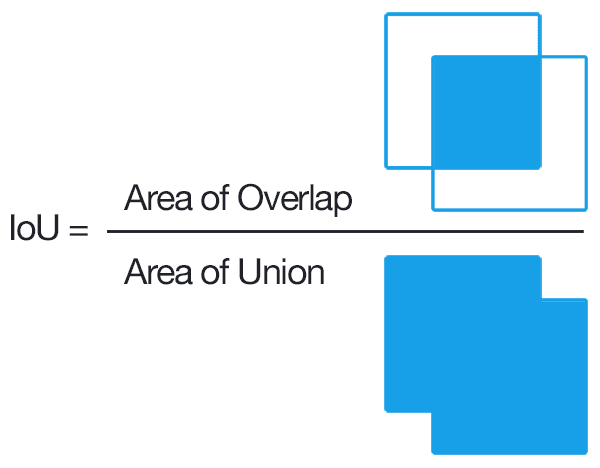

In [ ]:
def eval_bias(model, dataset, metric, num_classes = 9):
    results = torch.zeros((1, num_classes))
    test_loader = generate_dataloader(dataset, num_classes)
    for x, y in test_loader:
        results += metric(torch.softmax(model(x.cuda()), dim=1), y.cuda()).detach().cpu()

    return results/len(test_loader)

def generate_dataloader(dataset, num_classes):
    augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()]) # A.OneOf([A.Emboss(), Canny()
    test_set = BonyAnatomyJointSegmentationDataset(data_save_location, dataset.id, num_classes,
                                                   transforms=augmentations)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

    return test_loader

In [ ]:
multi_jaccard = MulticlassJaccardIndex(num_classes=9, average="none").cuda()
multi_jaccard.__name__ = "iou"

In [ ]:
data_records = pd.read_csv(data_location)

In [ ]:
male_group = data_records[data_records.P02SEX == "1: Male"].reset_index(drop=True)
female_group = data_records[data_records.P02SEX == "2: Female"].reset_index(drop=True)
white_caucasian_group = data_records[data_records.P02RACE == "1: White or Caucasian"].reset_index(drop=True)
black_aa_group = data_records[data_records.P02RACE == "2: Black or African American"].reset_index(drop=True)

#### Baseline Models

In [ ]:
gender_male_metrics_baseline = eval_bias(baseline_model, male_group, multi_jaccard)
gender_female_metrics_baseline = eval_bias(baseline_model, female_group, multi_jaccard)
race_white_metrics_baseline = eval_bias(baseline_model, white_caucasian_group, multi_jaccard)
race_black_metrics_baseline = eval_bias(baseline_model, black_aa_group, multi_jaccard)

base_dict = {
    "Gender: Male": gender_male_metrics_baseline.numpy().squeeze(),
    "Gender: Female": gender_female_metrics_baseline.numpy().squeeze(),
    "Race: White/Caucasian": race_white_metrics_baseline.numpy().squeeze(),
    "Race: Black/AA": race_black_metrics_baseline.numpy().squeeze(),
}

baseline_res = pd.DataFrame(base_dict).T
baseline_res["Average"] = baseline_res.mean(axis=1)
baseline_res.columns = [val for key, val in classes.items()] + ["Average"]
baseline_res

#### Balanced Models

In [ ]:
gender_male_metrics_balanced = eval_bias(balanced_gender_model, male_group, multi_jaccard)
gender_female_metrics_balanced = eval_bias(balanced_gender_model, female_group, multi_jaccard)

balanced_gender = {
    "Gender: Male": gender_male_metrics_balanced.numpy().squeeze(),
    "Gender: Female": gender_female_metrics_balanced.numpy().squeeze(),
}
balanced_gender_res = pd.DataFrame(balanced_gender).T
balanced_gender_res["Average"] =  balanced_gender_res.mean(axis=1)
balanced_gender_res.columns = [val for key, val in classes.items()] + ["Average"]

balanced_gender_res

In [ ]:
race_white_metrics_balanced = eval_bias(balanced_race_model, white_caucasian_group, multi_jaccard)
race_black_metrics_balanced = eval_bias(balanced_race_model, black_aa_group, multi_jaccard)

balanced_race = {
     "Race: White/Caucasian": race_white_metrics_balanced.numpy().squeeze(),
    "Race: Black/AA": race_black_metrics_balanced.numpy().squeeze(),
}
balanced_race_res = pd.DataFrame(balanced_race).T
balanced_race_res["Average"] = balanced_race_res.mean(axis=1)
balanced_race_res.columns = [val for key, val in classes.items()] + ["Average"]

balanced_race_res

#### Stratified Models

In [ ]:
gender_male_metrics_stratified = eval_bias(stratified_gender_model, male_group, multi_jaccard)
gender_female_metrics_stratified = eval_bias(stratified_gender_model, female_group, multi_jaccard)

strat_gender = {
    "Gender: Male": gender_male_metrics_stratified.numpy().squeeze(),
    "Gender: Female": gender_female_metrics_stratified.numpy().squeeze(),
}
strat_gender_res = pd.DataFrame(strat_gender).T
strat_gender_res["Average"] = strat_gender_res.mean(axis=1)
strat_gender_res.columns = [val for key, val in classes.items()] + ["Average"]
strat_gender_res

In [ ]:
race_white_metrics_stratified = eval_bias(stratified_race_model, white_caucasian_group, multi_jaccard)
race_black_metrics_stratified= eval_bias(stratified_race_model, black_aa_group, multi_jaccard)

strat_race = {
    "Race: White/Caucasian": race_white_metrics_stratified.numpy().squeeze(),
    "Race: Black/AA": race_black_metrics_stratified.numpy().squeeze(),
}
strat_race_res = pd.DataFrame(strat_race).T
strat_race_res["Average"] = strat_race_res.mean(axis=1)
strat_race_res.columns = [val for key, val in classes.items()] + ["Average"]
strat_race_res

#### Group Specific Models

In [ ]:
gender_male_metrics = eval_bias(baseline_male_model, male_group, multi_jaccard)

gender_male = {
    "Gender: Male": gender_male_metrics.numpy().squeeze(),
}
gender_male = pd.DataFrame(gender_male).T
gender_male["Average"] = gender_male.mean(axis=1)
gender_male.columns = [val for key, val in classes.items()] + ["Average"]
gender_male

In [ ]:
gender_female_metrics = eval_bias(baseline_female_model, female_group, multi_jaccard)

gender_female = {
    "Gender: Female": gender_female_metrics.numpy().squeeze(),
}
gender_female = pd.DataFrame(gender_female).T
gender_female["Average"] = gender_female.mean(axis=1)
gender_female.columns = [val for key, val in classes.items()] + ["Average"]
gender_female

In [ ]:
race_white_metrics = eval_bias(baseline_white_model, white_caucasian_group, multi_jaccard)

race_white = {
    "Race: White/Caucasian": race_white_metrics.numpy().squeeze(),
}
race_white = pd.DataFrame(race_white).T
race_white["Average"] = race_white.mean(axis=1)
race_white.columns = [val for key, val in classes.items()] + ["Average"]
race_white

In [ ]:
race_black_metrics = eval_bias(baseline_black_model, black_aa_group, multi_jaccard)

race_black = {
    "Race: Black/AA": race_black_metrics.numpy().squeeze(),
}
race_black = pd.DataFrame(race_black).T
race_black["Average"] = race_black.mean(axis=1)
race_black.columns = [val for key, val in classes.items()] + ["Average"]
race_black

## Step 4: Fairness Evaluation

To evaluate fairness, we utilize the Skewed Error Ratio (SER), which focuses specifically on evaluating potential biases in the algorithm’s prediction errors toward specific groups. SER, is defined as:


$$SER_{g}= \frac{Max_g (1 - IoU_g)}{Min_g ( 1- IoU_g)}
$$


It utilizes the ratio of highest to lowest error rate among protected groups, with $g$ denoting the considered protected groups. Higher values of SER present a higher presence of bias, while values closer to one are an indication of a lower presence of bias.


In [ ]:
def calc_fairness_score(data):
    sd = []
    ser = []

    for i, row in data.iterrows():
        sd.append(row[1:].std())
        min_group = row[1:].min()
        max_group = row[1:].max()
        ser.append((1 - min_group)/(1 - max_group))

    return sd, ser

#### Gender

In [ ]:
fairness_gender = {
    "Model": ["Baseline", "Balanced", "Stratified", "Group-Specific"],
    "Male": [baseline_res.loc["Gender: Male", "Average"],
             balanced_gender_res.loc["Gender: Male", "Average"],
             strat_gender_res.loc["Gender: Male", "Average"],
             gender_male.loc["Gender: Male", "Average"]],
    "Female":[baseline_res.loc["Gender: Female", "Average"],
             balanced_gender_res.loc["Gender: Female", "Average"],
             strat_gender_res.loc["Gender: Female", "Average"],
             gender_female.loc["Gender: Female", "Average"]]
}

fairness_df_gender = pd.DataFrame(fairness_gender)
sd, ser = calc_fairness_score(fairness_df_gender)
fairness_df_gender["SD"] = sd
fairness_df_gender["SER"] = ser

fairness_df_gender

#### Race

In [ ]:
fairness_race = {
    "Model": ["Baseline", "Balanced", "Stratified", "Group-Specific"],
    "White/Caucasian": [baseline_res.loc["Race: White/Caucasian", "Average"],
             balanced_race_res.loc["Race: White/Caucasian", "Average"],
             strat_race_res.loc["Race: White/Caucasian", "Average"],
             race_white.loc["Race: White/Caucasian", "Average"]],
    "Black/African American":[baseline_res.loc["Race: Black/AA", "Average"],
             balanced_race_res.loc["Race: Black/AA", "Average"],
             strat_race_res.loc["Race: Black/AA", "Average"],
             race_black.loc["Race: Black/AA", "Average"]]
}

fairness_df_race = pd.DataFrame(fairness_race)
sd, ser = calc_fairness_score(fairness_df_race)
fairness_df_race["SD"] = sd
fairness_df_race["SER"] = ser

fairness_df_race